# Customer Segmentation - Preprocessing and Training

This notebook will be used to prepare the data set for clsutering and to create a baseline clustering model. All data cleaning was done in [this](https://github.com/NickD-Dean/Springboard/blob/ce7358bfc84ceee14d287000eb132e8ff06a944b/Capstone%20Project%203/Code/03%20-%20Customer%20Segmentation%20Data%20Wrangling.ipynb) notebook, and exploratory analysis can be found [here](https://github.com/NickD-Dean/Springboard/blob/ce7358bfc84ceee14d287000eb132e8ff06a944b/Capstone%20Project%203/Code/04%20-%20Exploratory%20Data%20Analysis.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import matplotlib.colors
from scipy import stats
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
data = pd.read_parquet('../Data/Trimmed_Data')

In [3]:
data.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,CampaignsRedeemed,CampaignsSent,Percent_CampaignRedeemed,...,Num_stores_visited,Most_freq_store,Most_freq_time,First_active_day,Last_active_day,Recency,Frequency,Monetary,Avg_trips_week,Avg_shopping_lag
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,2,8,0.25,...,2,436.0,1456.0,51,706,5,0.120956,4330.16,1.264706,7.705882
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,0,4,0.00,...,2,359.0,1711.0,23,709,2,0.082982,3400.05,1.180000,11.827586
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,1,10,0.10,...,3,321.0,2149.0,65,706,5,0.158931,5534.97,1.569444,5.723214
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,7,10,0.70,...,1,323.0,1130.0,101,709,2,0.386779,13190.92,3.160920,2.218978
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,0,2,0.00,...,2,3316.0,657.0,98,690,21,0.137834,1512.02,1.689655,6.103093


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1 to 2499
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            801 non-null    object 
 1   Marital_status                 801 non-null    object 
 2   Income                         801 non-null    object 
 3   Homeowner_status               801 non-null    object 
 4   Household_comp                 801 non-null    object 
 5   Household_size                 801 non-null    object 
 6   Kids                           801 non-null    object 
 7   CampaignsRedeemed              801 non-null    int64  
 8   CampaignsSent                  801 non-null    int64  
 9   Percent_CampaignRedeemed       801 non-null    float64
 10  CouponRedeemed_Count           801 non-null    int64  
 11  CouponSent_Count               801 non-null    int64  
 12  Percent_CouponsRedeemed        801 non-null    fl

### Pre-processing steps:

1. I need to remove colinear features as identified in the previous EDA notebook. 

2. Remove categorical data, and one-hot encode this information. 

3. Remove outliers from the data set (I'll initially remove values which lie outside 3 standard deviations of the mean.)

4. Standardize skewed features using a log transform. (Ultimately decided against, with so many values of 'zero' in the data set it caused issues when transforming back into the original form for analysis)

5. Scale all numerical features using the MinMaxScaler to shift all data onto the same scale as one-hot encoded data.

#### Removing colinear features

In [5]:
# In the previous notebook I created a data frame that logged if features pairwise correlations were 'high', 'mid', 
# or 'low'.  I'll use this as a reference later on to determine if additional features should be dropped.

data = data.drop(['%_baskets_product_mailer', '%_baskets_product_displayed', 'Last_active_day'], axis=1)
idx = data.index
s3 = set(idx)

#### Separating out categorical data and one-hot encoding this data

In [6]:
cat = data.select_dtypes(exclude=np.number)

After more consideration there are several features in the categorical data which may provide some information, but have such a large array of options which can't be tied back to actions which a marketing team could potentially take.

As a result, I'm going to drop the categoriesh which represent the actual product id's of products purchased, and store id's. These features have large numbers of unique features which results in a highly sparse matrix that will influence clustering much more than other features which provide information which can be acted upon. 

In [7]:
cat = cat.drop(['Most_freq_product', 'Least_freq_product', 'High_volume_product', 'Most_freq_store'], axis=1)

In [8]:
# This does not include certain categories which ARE categorical but are not strings at this time
# I need to include most frequent store, most/least frequent product, high volume propduct, and most frequent time
cat.head()

,Age,Marital_status,Income,Homeowner_status,Household_comp,Household_size,Kids,Most_freq_dept,Least_freq_dept,Most_freq_time
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,GROCERY,FLORAL,1456.0
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,GROCERY,FLORAL,1711.0
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,GROCERY,DAIRY DELI,2149.0
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,GROCERY,AUTOMOTIVE,1130.0
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,GROCERY,SALAD BAR,657.0


In [9]:
Age = pd.get_dummies(cat.Age, drop_first=True, prefix='Age')
Marital = pd.get_dummies(cat.Marital_status, drop_first=True, prefix='Marital')
Income = pd.get_dummies(cat.Income, drop_first=True, prefix='Income')
Home = pd.get_dummies(cat.Homeowner_status, drop_first=True, prefix='Home')
Comp = pd.get_dummies(cat.Household_comp, drop_first=True, prefix='Composition')
Size = pd.get_dummies(cat.Household_size, drop_first=True, prefix='Size')
Kids = pd.get_dummies(cat.Kids, drop_first=True, prefix='Kids')

Dummy = pd.concat([Age, Marital, Income, Home, Comp, Size, Kids]
                 , axis=1)
Dummy.shape

(801, 34)

In [10]:
# I'm going to break down most_freqeunt_time from actual timestamps to either morning, afternoon, evening shoppers

Time = cat.Most_freq_time

Time = Time.astype('float')
Time = Time.astype('int')
# Define function to map to the Time series

def himidlow(x):
    if x < 1200: return 'Morning'
    elif x >= 1200 and x < 1700: return 'Afternoon'
    elif x >= 1700: return 'Evening'
    
Time = Time.map(himidlow)
Time = pd.get_dummies(Time, drop_first=True, prefix='Shopping_time')

In [11]:
Dummy = pd.concat([Age, Marital, Income, Home, Comp, Size, Kids, Time], axis=1)
Dummy.shape

(801, 36)

#### Handling Outliers

I've created a dataframe for the categorical information, next up is time to remove outliers from the numerical data and drop extraneous columns.

There are several columns here which aren't needed:

1. CampaignsRedeemed - this is redundant to information contained in CampaignsSent & Percent_CampaignsRedeemed

2. CouponRedeemed_Count - same logic as above

3. TypeA/TypeB/TypeC - for the same reasons as above

4. Min_loyalty_disc - this is zero for almost all households

5. Avg_trips_week - while quantitatively different from Frequency, this captures the same kind of behavior

In [21]:
num = data.select_dtypes(include = np.number)
num = num.drop(['CampaignsRedeemed', 'CouponRedeemed_Count', 'TypeA', 'TypeB', 'TypeC', 'Min_loyal_disc',
               'Avg_trips_week'], axis=1)
num.head()

,CampaignsSent,Percent_CampaignRedeemed,CouponSent_Count,Percent_CouponsRedeemed,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,...,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Max_loyal_disc,Num_stores_visited,First_active_day,Recency,Frequency,Monetary,Avg_shopping_lag
1,8,0.25,662,0.007553,0.375,0.50,0.125,677,13,303,...,0.936744,6.84,8.105116,23.30,2,51,5,0.120956,4330.16,7.705882
7,4,0.00,251,0.000000,0.250,0.75,0.000,829,13,348,...,0.515254,8.90,8.178136,33.57,2,23,2,0.082982,3400.05,11.827586
8,10,0.10,669,0.001495,0.300,0.70,0.000,1288,20,462,...,0.250885,4.50,9.542478,54.69,3,65,5,0.158931,5534.97,5.723214
13,10,0.70,668,0.031437,0.300,0.60,0.100,1008,16,373,...,1.121345,16.10,5.917055,34.72,1,101,2,0.386779,13190.92,2.218978
16,2,0.00,221,0.000000,0.500,0.50,0.000,282,10,191,...,0.010204,1.00,1.747857,11.24,2,98,21,0.137834,1512.02,6.103093


In [22]:
# Removing outliers which are 3 standard deviations from the mean of each feature
z_scores = np.abs(stats.zscore(num))
outliers_threshold = 3  
mask = (z_scores <= outliers_threshold).all(axis=1)
NUM = num[mask]
NUM

,CampaignsSent,Percent_CampaignRedeemed,CouponSent_Count,Percent_CouponsRedeemed,PercentTypeA,PercentTypeB,PercentTypeC,Count_products,Count_depts,Count_sub_cagtegory,...,Avg_coupon_disc,Max_coupon_disc,Avg_loyalty_disc,Max_loyal_disc,Num_stores_visited,First_active_day,Recency,Frequency,Monetary,Avg_shopping_lag
1,8,0.250000,662,0.007553,0.375000,0.500000,0.125000,677,13,303,...,0.936744,6.84,8.105116,23.30,2,51,5,0.120956,4330.16,7.705882
7,4,0.000000,251,0.000000,0.250000,0.750000,0.000000,829,13,348,...,0.515254,8.90,8.178136,33.57,2,23,2,0.082982,3400.05,11.827586
8,10,0.100000,669,0.001495,0.300000,0.700000,0.000000,1288,20,462,...,0.250885,4.50,9.542478,54.69,3,65,5,0.158931,5534.97,5.723214
16,2,0.000000,221,0.000000,0.500000,0.500000,0.000000,282,10,191,...,0.010204,1.00,1.747857,11.24,2,98,21,0.137834,1512.02,6.103093
17,5,0.000000,866,0.000000,1.000000,0.000000,0.000000,444,12,238,...,0.616935,16.00,8.948065,63.78,4,24,22,0.174402,5139.63,5.406504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,9,0.555556,674,0.016320,0.333333,0.555556,0.111111,992,15,438,...,0.392857,9.71,6.665378,27.57,10,62,7,0.167370,6327.51,5.440678
2496,5,0.600000,612,0.017974,0.600000,0.200000,0.200000,758,16,324,...,0.819048,15.90,17.699841,49.58,3,117,28,0.088608,4339.66,9.129032
2497,3,0.000000,574,0.000000,1.000000,0.000000,0.000000,991,16,435,...,0.076199,5.59,6.068009,68.21,12,78,11,0.310830,7111.98,2.827273
2498,6,0.000000,600,0.000000,0.500000,0.333333,0.166667,642,14,285,...,0.000000,0.00,1.624419,28.26,7,105,1,0.241913,2601.60,3.538012


This resulted in far fewer columns, which indicates that there is likely a cluster of consumers who are 'high end' - these are more than likely the 'corporate' customers I mentioned in a previous notebook. I'm going to move forward WITHOUT removing outliers and 'throw the kitchen sink' at the clustering algorithm, I can compare the silhouette scores with and without outliers to see if there are more patterns that appear. 

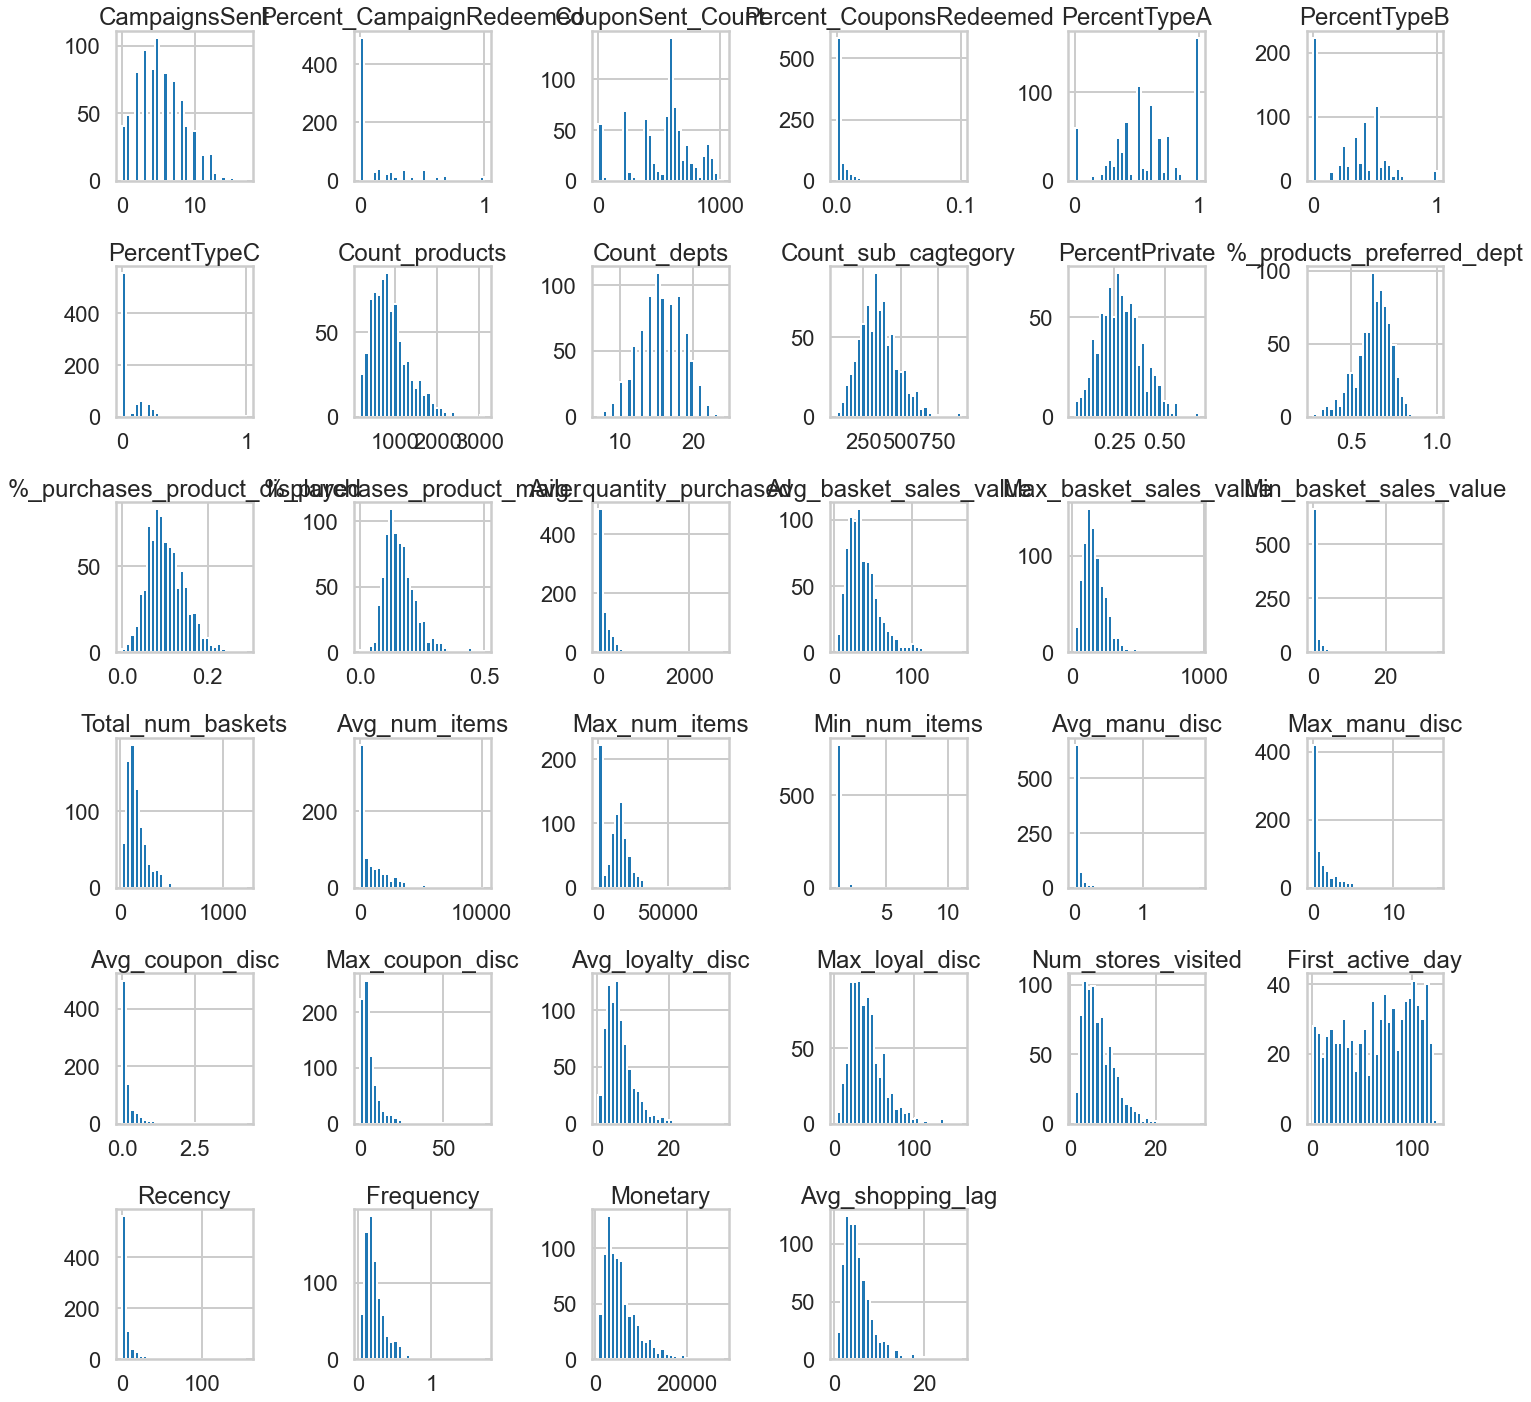

In [23]:
# Next I need to check and see if there are any issues with skewed data that would indicate a need for a log 
# transformation
num.hist(bins=30, figsize=(20,20))
plt.tight_layout()

In [24]:
num.head()
cols = list(num.columns)

In [25]:
# There is some definite skew
num = num.applymap(np.abs)
scaler = MinMaxScaler()
scaler.fit(num)
num = scaler.transform(num)
num = pd.DataFrame(num, columns=cols, index=idx)

Now that the data set has been prepared for clustering analysis, it's time to instantiate the clustering model and get some initial results.

### Building initial clustering model

I'm going to build and fit a kmeans model to the data set and see what initial results provide as a baseline.

In [26]:
# Combining both dataframes together and computing clusters
new = pd.concat([num,Dummy], axis=1)
k = KMeans(random_state=42)
fit = k.fit_predict(new)
centroid = k.cluster_centers_

In [27]:
# Calculating silhouette score
label = k.labels_
score = silhouette_score(new, label)
score

0.1055764534701953

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

<pre>

# Conclusion

According to the above chart, 0.07 is a horrendous clsutering score, and there has been almost no substantial structure found in the data. It's clear that I need to take several steps in the next notebook on this data in order to tease out proper clusters in the data set. 


1. Apply an agglomerative clustering model to the data and get a baseline score for that model as well. 


2. Examine clusters from both the Agglomerative and KMeans models to see if the clusters provide clear personas.


**If needed**

3. Apply PCA (MCA) to categorical data and try clustering with that transformed data


4. Remove households which are ONLY outliers in more than one feature if there seems to be no pattern with the way outliers are clustered.


5. Remove one pair of all 'high' correlated features for clustering


At this point if clustering with KMeans and Agglomerative algorithms is not producing the needed results I'll resort to RFM analyssis to create the needed cohorts. 

In [28]:
# Saving the transformed data frames to parquet files for easy access in the next notebook
cat.to_parquet('../Data/Cust_seg_categorical')
num.to_parquet('../Data/Cust_seg_numerical')
new.to_parquet('../Data/Cust_seg')